In [1]:
import kagglehub
adityajn105_flickr30k_path = kagglehub.dataset_download('adityajn105/flickr30k')

print('Data source import complete.')


Using Colab cache for faster access to the 'flickr30k' dataset.
Data source import complete.


In [2]:
import os
import pickle
import random
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

In [3]:
def find_image_dir(base_path): # Changed to take base_path
    # Walk through the base_path to find where the images actually are
    for root, dirs, files in os.walk(base_path):
        # Look for the folder containing a high volume of jpg files
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None
IMAGE_DIR = find_image_dir(adityajn105_flickr30k_path) # Use the downloaded path
OUTPUT_FILE = 'flickr30k_features.pkl'
if IMAGE_DIR:
    print(f" Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added to the notebook.")
# --- THE DATASET CLASS ---
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir
    def __len__(self):
        return len(self.img_names)
    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name
# --- REMAINDER OF THE PIPELINE (AS BEFORE) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1]) # Feature vector only
model = nn.DataParallel(model).to(device)
model.eval()
transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)
features_dict = {}
with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()
with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)
print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")

 Found images at: /kaggle/input/flickr30k/Images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting Features: 100%|██████████| 249/249 [03:04<00:00,  1.35it/s]


Success! 31783 images processed and saved to flickr30k_features.pkl


Newer approch

In [ ]:
# import random
# from PIL import Image
# import os

# # Select two random images from the test set
# images_to_export = random.sample(test_imgs, 2)

# for i, img_name in enumerate(images_to_export):
#     img_path = os.path.join(adityajn105_flickr30k_path, "Images", img_name)
#     img = Image.open(img_path).convert('RGB')
#     output_filename = f"exported_image_{i+1}_{img_name}"
#     img.save(output_filename)
#     print(f"Exported {img_name} to {output_filename}")

# Config Files

In [24]:

class Config:
    IMAGE_FEATURE_DIM = 2048
    EMBEDDING_DIM = 512
    HIDDEN_DIM = 512
    ENCODER_LAYERS = 1
    DECODER_LAYERS = 1
    DROPOUT = 0.5
    BATCH_SIZE = 64
    LEARNING_RATE = 5e-4
    NUM_EPOCHS = 5
    MAX_CAPTION_LENGTH = 50
    MIN_WORD_FREQ = 5
    LABEL_SMOOTHING = 0.1
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()
print(f"Using device: {config.DEVICE}")

Using device: cuda


In [25]:
def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r'[^a-z]+', ' ', caption)
    caption = caption.strip()
    return caption

with open('flickr30k_features.pkl', 'rb') as f:
    features_dict = pickle.load(f)

captions_dict = {}
with open(os.path.join(adityajn105_flickr30k_path, 'captions.txt'), 'r', encoding='utf-8') as f:
    next(f)
    for line in f:
        img, cap = line.strip().split(",", 1)
        if img not in captions_dict:
            captions_dict[img] = []
        captions_dict[img].append(clean_caption(cap))

print(f"Loaded features for {len(features_dict)} images.")
print(f"Loaded captions for {len(captions_dict)} images.")


Loaded features for 31783 images.
Loaded captions for 31783 images.


In [26]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<START>", 2: "<END>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<START>": 1, "<END>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        for sentence in sentence_list:
            for word in sentence.split():
                frequencies[word] += 1

        idx = 4
        for word, count in frequencies.items():
            if count >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = text.split()
        return [self.stoi["<START>"]] + [self.stoi.get(word, self.stoi["<UNK>"]) for word in tokenized_text] + [self.stoi["<END>"]]

all_captions = [cap for caps in captions_dict.values() for cap in caps]
vocab = Vocabulary(freq_threshold=config.MIN_WORD_FREQ)
vocab.build_vocabulary(all_captions)
vocab_size = len(vocab)
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 7611


In [27]:

class FlickrDataset(Dataset):
    def __init__(self, features_dict, captions_dict, vocab):
        self.features_dict = features_dict
        self.captions_dict = captions_dict
        self.vocab = vocab
        self.samples = []
        for img_name, caps in captions_dict.items():
            if img_name in features_dict:
                for cap in caps:
                    if len(cap.split()) <= config.MAX_CAPTION_LENGTH:
                        self.samples.append((img_name, cap))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, caption = self.samples[idx]
        feature = torch.tensor(self.features_dict[img_name], dtype=torch.float32)
        numericalized_caption = torch.tensor(self.vocab.numericalize(caption), dtype=torch.long)
        return feature, numericalized_caption

def collate_fn(batch):
    features = [item[0] for item in batch]
    captions = [item[1] for item in batch]
    features = torch.stack(features)
    captions = pad_sequence(captions, batch_first=True, padding_value=vocab.stoi["<PAD>"])
    return features, captions

dataset = FlickrDataset(features_dict, captions_dict, vocab)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_set, batch_size=config.BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=2)


# Seq2Seq Model

In [28]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, dropout=0.3):
        super(LSTMEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.feature_proj = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.LayerNorm(hidden_dim), nn.ReLU(), nn.Dropout(dropout))
        self.h_init = nn.Linear(hidden_dim, hidden_dim * num_layers)
        self.c_init = nn.Linear(hidden_dim, hidden_dim * num_layers)

    def forward(self, images):
        features = self.feature_proj(images)
        h0 = self.h_init(features).view(-1, self.num_layers, self.hidden_dim).permute(1, 0, 2).contiguous()
        c0 = self.c_init(features).view(-1, self.num_layers, self.hidden_dim).permute(1, 0, 2).contiguous()
        return h0, c0

class LSTMDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2, dropout=0.3):
        super(LSTMDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, captions, h0, c0):
        embeds = self.dropout(self.embedding(captions))
        lstm_out, _ = self.lstm(embeds, (h0, c0))
        outputs = self.linear(lstm_out)
        return outputs


In [29]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, images, captions):
        h0, c0 = self.encoder(images)
        captions_input = captions[:, :-1]
        outputs = self.decoder(captions_input, h0, c0)
        return outputs

encoder = LSTMEncoder(config.IMAGE_FEATURE_DIM, config.HIDDEN_DIM, config.ENCODER_LAYERS, config.DROPOUT)
decoder = LSTMDecoder(vocab_size, config.EMBEDDING_DIM, config.HIDDEN_DIM, config.DECODER_LAYERS, config.DROPOUT)
model = ImageCaptioningModel(encoder, decoder, config.DEVICE).to(config.DEVICE)


# Training Loop

In [30]:
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"], label_smoothing=config.LABEL_SMOOTHING)
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

train_losses, val_losses = [], []

for epoch in range(config.NUM_EPOCHS):
    model.train()
    train_loss = 0
    for imgs, caps in tqdm(train_loader, desc=f"Epoch {epoch+1} Train"):
        imgs = imgs.to(config.DEVICE)
        caps = caps.to(config.DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs, caps)
        targets = caps[:, 1:]
        loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, caps in tqdm(val_loader, desc=f"Epoch {epoch+1} Val"):
            imgs = imgs.to(config.DEVICE)
            caps = caps.to(config.DEVICE)
            outputs = model(imgs, caps)
            targets = caps[:, 1:]
            loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{config.NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")

Epoch 1 Val: 100%|██████████| 249/249 [00:03<00:00, 82.08it/s]


Epoch 1/5 | Train Loss: 4.5267 | Val Loss: 4.0885 | LR: 0.000500


Epoch 2 Val: 100%|██████████| 249/249 [00:02<00:00, 85.39it/s]


Epoch 2/5 | Train Loss: 4.0108 | Val Loss: 3.9095 | LR: 0.000500


Epoch 3 Val: 100%|██████████| 249/249 [00:02<00:00, 85.16it/s]


Epoch 3/5 | Train Loss: 3.8593 | Val Loss: 3.8284 | LR: 0.000500


Epoch 4 Val: 100%|██████████| 249/249 [00:02<00:00, 84.65it/s]


Epoch 4/5 | Train Loss: 3.7679 | Val Loss: 3.7795 | LR: 0.000500


Epoch 5 Val: 100%|██████████| 249/249 [00:02<00:00, 85.00it/s]


Epoch 5/5 | Train Loss: 3.7013 | Val Loss: 3.7463 | LR: 0.000500


In [31]:
def generate_caption(model, image_feature, vocab, max_len=20):
    model.eval()
    with torch.no_grad():
        h0, c0 = model.encoder(image_feature.unsqueeze(0).to(config.DEVICE))
        inputs = torch.tensor([vocab.stoi["<START>"]]).unsqueeze(0).to(config.DEVICE)
        caption = []
        for _ in range(max_len):
            embeds = model.decoder.embedding(inputs)
            lstm_out, (h0, c0) = model.decoder.lstm(embeds, (h0, c0))
            outputs = model.decoder.linear(lstm_out.squeeze(1))
            predicted = outputs.argmax(1)
            if predicted.item() == vocab.stoi["<END>"]:
                break
            caption.append(vocab.itos[predicted.item()])
            inputs = predicted.unsqueeze(0)
    return " ".join(caption)

# Test on a few validation samples
indices = random.sample(range(len(val_set)), 5)
for idx in indices:
    feature, target_cap = val_set[idx]
    predicted = generate_caption(model, feature, vocab)
    target_words = [vocab.itos[i.item()] for i in target_cap if i.item() not in [0, 1, 2]]
    print(f"Target: {' '.join(target_words)}")
    print(f"Pred: {predicted}\n")


Target: girl jumping over wave
Pred: a girl in a bathing suit is jumping into the water

Target: a young boy stands on a wide floor with his mouth open
Pred: a woman in a red dress is dancing

Target: a man in light blue is chasing after a man in black and white stripes while playing soccer and the second man s teammates look on
Pred: a soccer player in a red uniform is running on the field

Target: four children are running and playing tag
Pred: a woman in a red shirt and a man in a black shirt are walking down a hill

Target: a black man with facial hair wears a navy hat and blue jacket in front of a white background
Pred: a man in a blue hat and a blue hat is holding a red cup



# Plotting Loss vs Epoch

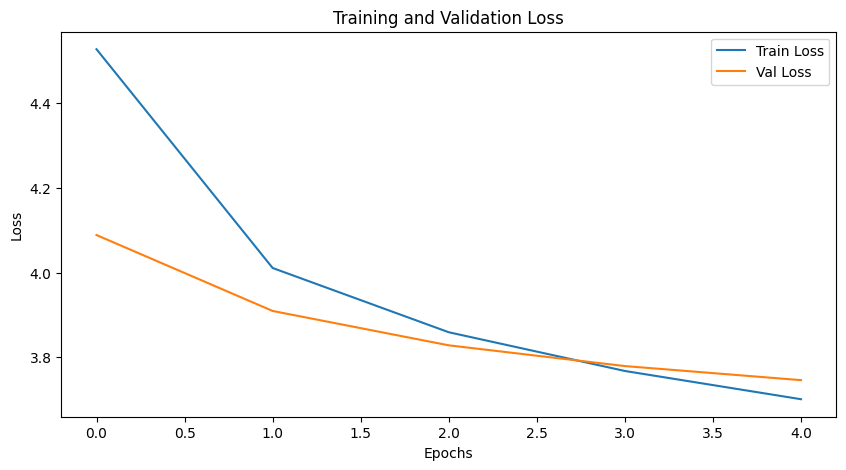

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.savefig("loss_curve.png")
plt.show()


# Model inference

In [33]:
def generate_caption_greedy(model, image_feature, vocab, max_len=30):
    model.eval()
    with torch.no_grad():
        h0, c0 = model.encoder(image_feature.unsqueeze(0).to(config.DEVICE))
        inputs = torch.tensor([vocab.stoi["<START>"]]).unsqueeze(0).to(config.DEVICE)
        caption = []
        for _ in range(max_len):
            embeds = model.decoder.embedding(inputs)
            lstm_out, (h0, c0) = model.decoder.lstm(embeds, (h0, c0))
            outputs = model.decoder.linear(lstm_out.squeeze(1))
            if vocab.stoi["<UNK>"] < outputs.shape[1]:
                outputs[:, vocab.stoi["<UNK>"]] = float('-inf')
            predicted = outputs.argmax(1)
            if predicted.item() == vocab.stoi["<END>"]:
                break
            caption.append(vocab.itos[predicted.item()])
            inputs = predicted.unsqueeze(0)
    return " ".join(caption)


def generate_caption_beam(model, image_feature, vocab, beam_width=3, max_len=30):
    model.eval()
    with torch.no_grad():
        h0, c0 = model.encoder(image_feature.unsqueeze(0).to(config.DEVICE))
        seqs = [[[vocab.stoi["<START>"]], 0.0, (h0, c0)]]
        for _ in range(max_len):
            all_cands = []
            for seq, score, state in seqs:
                if seq[-1] == vocab.stoi["<END>"]:
                    all_cands.append([seq, score, state])
                    continue
                inp = torch.tensor([seq[-1]]).unsqueeze(0).to(config.DEVICE)
                embeds = model.decoder.embedding(inp)
                lstm_out, new_state = model.decoder.lstm(embeds, state)
                logits = model.decoder.linear(lstm_out[:, -1, :])
                if vocab.stoi["<UNK>"] < logits.shape[1]:
                    logits[:, vocab.stoi["<UNK>"]] = float('-inf')
                logp = torch.log_softmax(logits, dim=1)
                topk = torch.topk(logp, beam_width)
                for k in range(beam_width):
                    cand = seq + [topk.indices[0, k].item()]
                    sc = score + topk.values[0, k].item()
                    all_cands.append([cand, sc, new_state])
            seqs = sorted(all_cands, key=lambda x: x[1], reverse=True)[:beam_width]
            if all(s[0][-1] == vocab.stoi["<END>"] for s in seqs):
                break
        best = seqs[0][0]
        words = [vocab.itos[i] for i in best if i not in [vocab.stoi["<START>"], vocab.stoi["<END>"], vocab.stoi["<PAD>"]]]
    return " ".join(words)



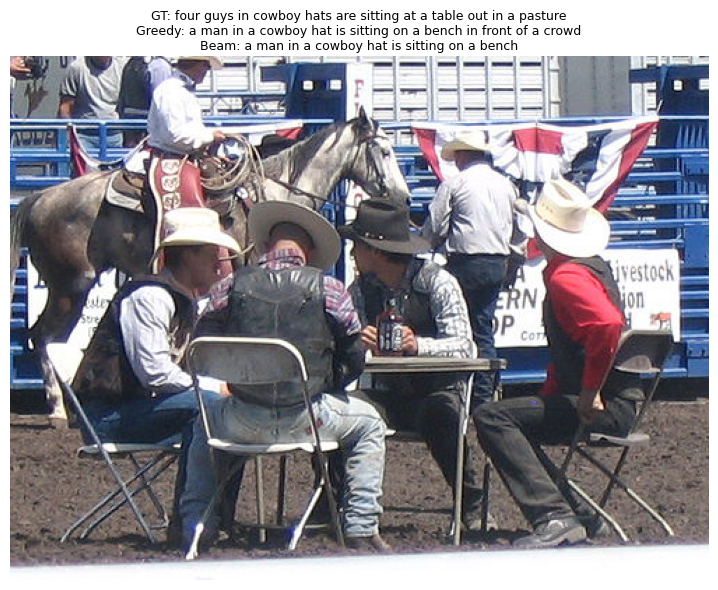

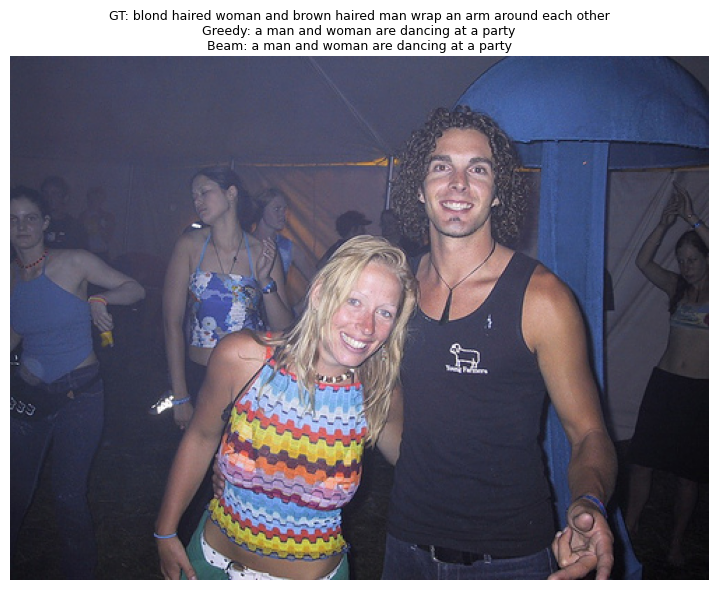

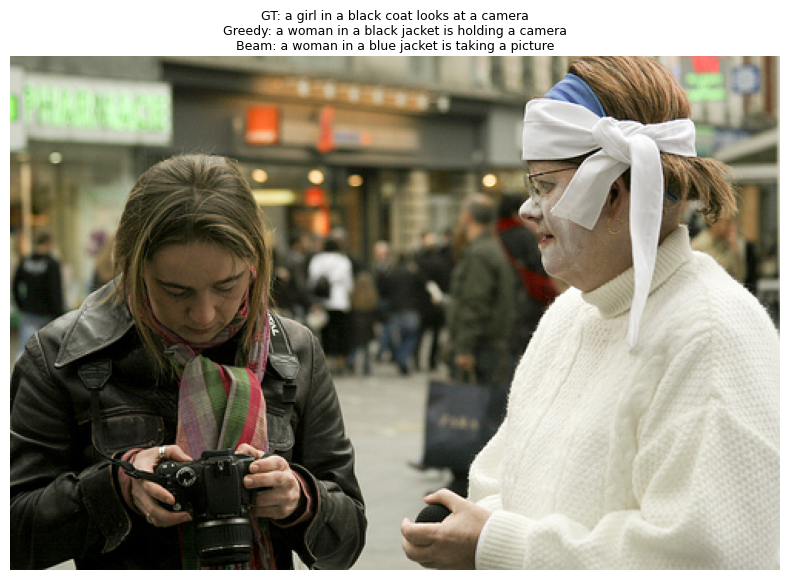

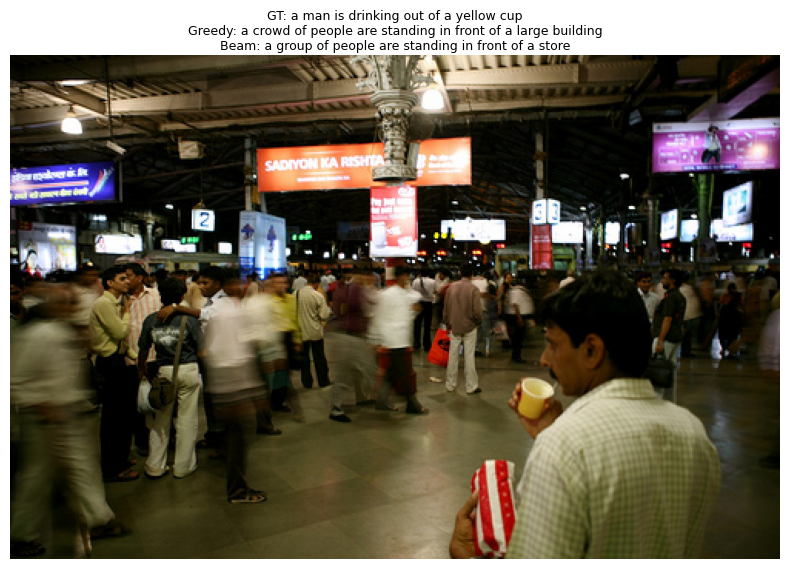

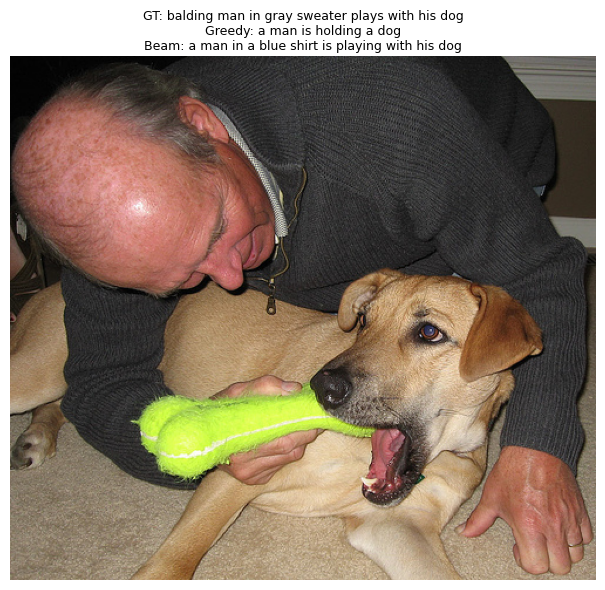

In [34]:
all_imgs = list(captions_dict.keys())
random.shuffle(all_imgs)
test_imgs = all_imgs[int(0.9 * len(all_imgs)):]

samples = random.sample(test_imgs, 5)
for name in samples:
    img_path = os.path.join(adityajn105_flickr30k_path, "Images", name)
    img = Image.open(img_path)
    feat = torch.tensor(features_dict[name]).to(config.DEVICE)
    greedy_cap = generate_caption_greedy(model, feat, vocab)
    beam_cap = generate_caption_beam(model, feat, vocab, beam_width=3)
    gt = random.choice(captions_dict[name])
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"GT: {gt}\nGreedy: {greedy_cap}\nBeam: {beam_cap}", fontsize=9, wrap=True)
    plt.tight_layout()
    plt.show()



# Model perfomance Evaluation

In [35]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_precision_recall_f1(reference_tokens, candidate_tokens):
    ref_counts = Counter(reference_tokens)
    cand_counts = Counter(candidate_tokens)
    overlap = sum((ref_counts & cand_counts).values())
    precision = overlap / len(candidate_tokens) if len(candidate_tokens) > 0 else 0
    recall = overlap / sum(ref_counts.values()) if sum(ref_counts.values()) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

def evaluate_model_new(test_imgs, features_dict, captions_dict, model, vocab, beam_size=3):
    bleu4_scores = []
    precisions = []
    recalls = []
    f1s = []
    smooth = SmoothingFunction().method1
    print(f"Evaluating on {len(test_imgs)} test images using Beam Search (k={beam_size})...")
    for name in tqdm(test_imgs):
        feat = torch.tensor(features_dict[name]).to(config.DEVICE)
        pred_caption = generate_caption_beam(model, feat, vocab, beam_width=beam_size)
        pred_words = pred_caption.split()
        references = [cap.split() for cap in captions_dict[name]]
        score = sentence_bleu(references, pred_words, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)
        bleu4_scores.append(score)
        local_p, local_r, local_f1 = 0, 0, 0
        for ref in references:
            p, r, f = calculate_precision_recall_f1(ref, pred_words)
            if f > local_f1:
                local_p, local_r, local_f1 = p, r, f
        precisions.append(local_p)
        recalls.append(local_r)
        f1s.append(local_f1)
    print("\n--- Evaluation Results ---")
    print(f"BLEU-4: {np.mean(bleu4_scores):.4f}")
    print(f"Precision: {np.mean(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f}")
    print(f"F1-Score: {np.mean(f1s):.4f}")
    return np.mean(bleu4_scores)

evaluate_model_new(test_imgs[:100], features_dict, captions_dict, model, vocab, beam_size=3)


Evaluating on 100 test images using Beam Search (k=3)...


100%|██████████| 100/100 [00:02<00:00, 40.59it/s]


--- Evaluation Results ---
BLEU-4: 0.2107
Precision: 0.5246
Recall: 0.4361
F1-Score: 0.4633


np.float64(0.2107105577057737)

# Exporting model

In [36]:
import json

EXPORT_DIR = "export"
os.makedirs(EXPORT_DIR, exist_ok=True)

MODEL_PATH = os.path.join(EXPORT_DIR, "model.pth")
VOCAB_PATH = os.path.join(EXPORT_DIR, "vocab.pkl")
CONFIG_PATH = os.path.join(EXPORT_DIR, "config.json")

torch.save(model.state_dict(), MODEL_PATH)
print(f"Saved model to {MODEL_PATH}")

with open(VOCAB_PATH, 'wb') as f:
    pickle.dump({'stoi': vocab.stoi, 'itos': vocab.itos}, f)
print(f"Saved vocab to {VOCAB_PATH}")

export_config = {
    'image_feature_dim': config.IMAGE_FEATURE_DIM,
    'embedding_dim': config.EMBEDDING_DIM,
    'hidden_dim': config.HIDDEN_DIM,
    'encoder_layers': config.ENCODER_LAYERS,
    'decoder_layers': config.DECODER_LAYERS,
    'dropout': config.DROPOUT,
    'vocab_size': vocab_size
}
with open(CONFIG_PATH, 'w') as f:
    json.dump(export_config, f, indent=2)
print(f"Saved config to {CONFIG_PATH}")
print("Export complete! Download the 'export' folder for app.py.")


Saved model to export/model.pth
Saved vocab to export/vocab.pkl
Saved config to export/config.json
Export complete! Download the 'export' folder for app.py.
